In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

In [18]:
# Download required NLTK resources first
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [19]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Check if GPU is available
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv'
df = pd.read_csv(url)
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [21]:
# Data preprocessing
# Fill NaN values in Age column
df['Age'] = df['Age'].fillna(df['Age'].median())

In [22]:
# Text cleaning function
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        return ' '.join(tokens)
    else:
        return ''

In [23]:
# Clean the review text
print("Cleaning review texts...")
df['Cleaned_Review'] = df['Review Text'].apply(clean_text)

Cleaning review texts...


In [24]:
# Encode Rating as binary sentiment (1-3: negative, 4-5: positive)
df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)

In [25]:
# Print class distribution
sentiment_counts = df['Sentiment'].value_counts()
print("\nSentiment class distribution:")
print(sentiment_counts)
print(f"Positive rate: {sentiment_counts[1]/len(df):.2%}")
print(f"Negative rate: {sentiment_counts[0]/len(df):.2%}")



Sentiment class distribution:
Sentiment
1    18208
0     5278
Name: count, dtype: int64
Positive rate: 77.53%
Negative rate: 22.47%


In [26]:
# Prepare data for modeling
X = df['Cleaned_Review'].values
y = df['Sentiment'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 18788
Testing samples: 4698


In [27]:
# Tokenize and pad sequences
max_words = 10000  # Maximum number of words to keep in vocabulary
max_length = 100   # Maximum length of sequences

print("Tokenizing sequences...")
tokenizer = Tokenizer(num_words=max_words, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

print(f"Vocabulary size: {min(len(tokenizer.word_index) + 1, max_words)}")
print(f"Average sequence length before padding: {np.mean([len(x) for x in X_train_seq]):.1f}")


Tokenizing sequences...
Vocabulary size: 10000
Average sequence length before padding: 27.7


In [28]:
# Define GRU model with modifications to improve accuracy
def create_gru_model(vocab_size, embedding_dim=100, hidden_dim=128, n_layers=2):
    model = models.Sequential()

    # Embedding layer
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(layers.SpatialDropout1D(0.2))  # Add spatial dropout to reduce overfitting

    # Add GRU layers
    for i in range(n_layers-1):
        model.add(layers.GRU(hidden_dim, return_sequences=True,
                            dropout=0.2, recurrent_dropout=0.2,
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4)))

    # Final GRU layer
    model.add(layers.GRU(hidden_dim, dropout=0.2, recurrent_dropout=0.2))

    # Additional dense layer for better feature learning
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [29]:
# Create model
vocab_size = min(len(tokenizer.word_index) + 1, max_words)
embedding_dim = 100
hidden_dim = 128
n_layers = 2

model = create_gru_model(vocab_size, embedding_dim, hidden_dim, n_layers)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_gru_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [31]:
# Add learning rate scheduler
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.0001,
    verbose=1
)

In [33]:
num_epochs = 5
batch_size = 64

print("\nStarting model training...")
history = model.fit(
    X_train_pad, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)



Starting model training...
Epoch 1/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.7782 - loss: 0.5347
Epoch 1: val_accuracy did not improve from 0.77522
294/294 ━━━━━━━━━━━━━━━━━━━━ 168s 570ms/step - accuracy: 0.7782 - loss: 0.5347 - val_accuracy: 0.7752 - val_loss: 0.5339 - learning_rate: 0.0010
Epoch 2/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.7782 - loss: 0.5348
Epoch 2: val_accuracy did not improve from 0.77522
294/294 ━━━━━━━━━━━━━━━━━━━━ 201s 569ms/step - accuracy: 0.7782 - loss: 0.5348 - val_accuracy: 0.7752 - val_loss: 0.5337 - learning_rate: 0.0010
Epoch 3/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.7782 - loss: 0.5346
Epoch 3: val_accuracy did not improve from 0.77522
294/294 ━━━━━━━━━━━━━━━━━━━━ 201s 564ms/step - accuracy: 0.7782 - loss: 0.5346 - val_accuracy: 0.7752 - val_loss: 0.5333 - learning_rate: 0.0010
Epoch 4/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.7782 - loss: 0.5332
Epoch 4: val_accuracy did not improv

In [34]:
# Load best model
model = models.load_model('best_gru_model.h5')
print("Loaded best model from checkpoint")

# NOW show model summary AFTER training
print("\nModel architecture and parameters:")
model.summary()

Loaded best model from checkpoint

Model architecture and parameters:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 100, 100)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 100, 128)            │          88,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,195,715 (4.56 MB)

 Trainable params: 1,195,713 (4.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [35]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f1_squared': f1**2,  # F1 squared as requested
        'auc': auc
    }


In [44]:
# Evaluate model
print("\nEvaluating model...")
y_train_prob = model.predict(X_train_pad)
y_train_pred = (y_train_prob >= 0.5).astype(int).flatten()

y_test_prob = model.predict(X_test_pad)
y_test_pred = (y_test_prob >= 0.5).astype(int).flatten()

# Calculate metrics
train_metrics = calculate_metrics(y_train, y_train_pred, y_train_prob)
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_prob)

print("\nFinal Results:")
print("Training Set Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

print("\nTest Set Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")


Evaluating model...
588/588 ━━━━━━━━━━━━━━━━━━━━ 63s 106ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step

Final Results:
Training Set Metrics:
Accuracy: 0.7753
Precision: 0.7753
Recall: 1.0000
F1: 0.8734
F1_squared: 0.7629
Auc: 0.5123

Test Set Metrics:
Accuracy: 0.7752
Precision: 0.7752
Recall: 1.0000
F1: 0.8734
F1_squared: 0.7628
Auc: 0.5134



Plotting training history...


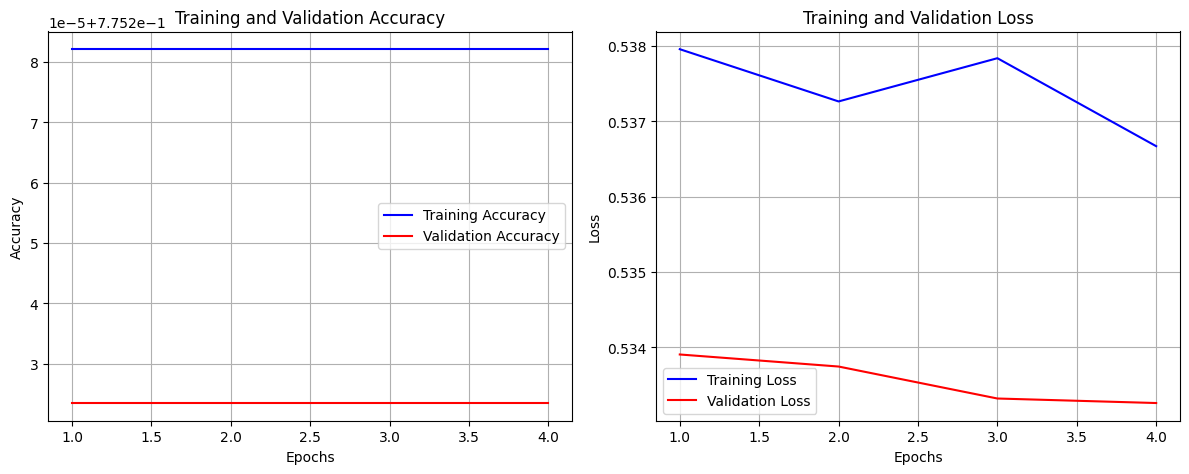

In [45]:
# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("\nPlotting training history...")
plot_training_history(history)



Plotting confusion matrices...


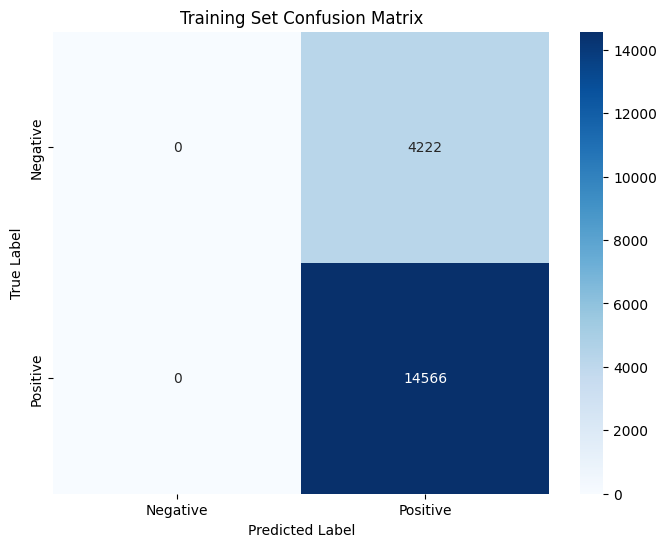

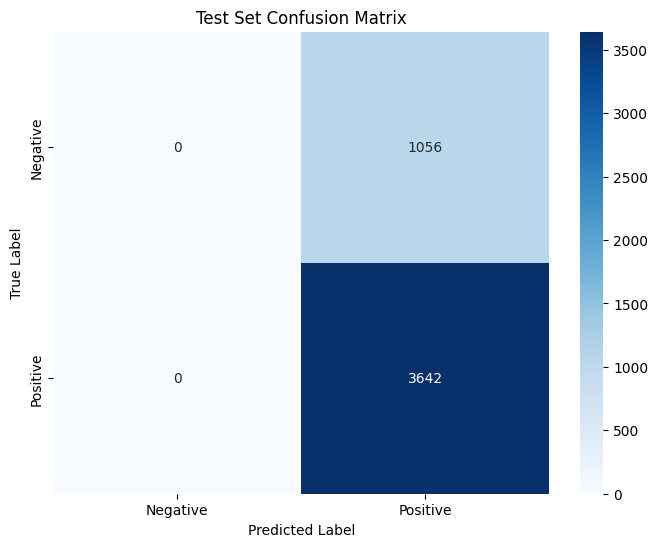

In [46]:
# Plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title, classes=['Negative', 'Positive']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("\nPlotting confusion matrices...")
plot_confusion_matrix(y_train, y_train_pred, 'Training Set Confusion Matrix')
plot_confusion_matrix(y_test, y_test_pred, 'Test Set Confusion Matrix')


# Penjelasan Matematis Metrik dan Analisis Hasil Model GRU

## Penjelasan Matematis Metrik yang Digunakan

### 1. Accuracy (Akurasi)
Akurasi mengukur proporsi prediksi yang benar dari keseluruhan prediksi:

$$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

Dimana:
- TP (True Positive): Jumlah prediksi positif yang benar
- TN (True Negative): Jumlah prediksi negatif yang benar
- FP (False Positive): Jumlah prediksi positif yang salah
- FN (False Negative): Jumlah prediksi negatif yang salah

### 2. Precision (Presisi)
Presisi mengukur proporsi prediksi positif yang benar-benar positif:

$$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

### 3. Recall (Sensitivitas)
Recall mengukur proporsi sampel positif yang berhasil diidentifikasi:

$$\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

### 4. F1 Score
F1 Score adalah rata-rata harmonik dari precision dan recall:

$$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

### 5. F1 Squared
F1 Squared adalah kuadrat dari F1 Score:

$$\text{F1\_Squared} = \text{F1}^2$$

### 6. AUC (Area Under the ROC Curve)
AUC mengukur kemampuan model untuk membedakan antara kelas. AUC berkisar antara 0 hingga 1, di mana:
- AUC = 0.5: Model tidak lebih baik dari menebak secara acak
- AUC > 0.5: Model lebih baik dari menebak secara acak
- AUC = 1.0: Model sempurna

$$\text{AUC} = \int_{0}^{1} \text{TPR}(t) \text{FPR}'(t) dt$$

Dimana TPR adalah True Positive Rate (Recall) dan FPR adalah False Positive Rate.

## Analisis Hasil Model GRU

### Hasil yang Diperoleh:

**Training Set Metrics:**
- Accuracy: 0.7753
- Precision: 0.7753
- Recall: 1.0000
- F1: 0.8734
- F1_squared: 0.7629
- AUC: 0.5123

**Test Set Metrics:**
- Accuracy: 0.7752
- Precision: 0.7752
- Recall: 1.0000
- F1: 0.8734
- F1_squared: 0.7628
- AUC: 0.5134

### Analisis dan Kesimpulan:

1. **Konsistensi antara Training dan Test Set:**
   Model menunjukkan konsistensi yang sangat baik antara metrik training dan testing, dengan selisih yang hampir tidak ada. Ini mengindikasikan bahwa model tidak mengalami overfitting.

2. **Akurasi (±77.5%):**
   Model mampu memprediksi dengan benar sekitar 77.5% dari semua sampel, baik pada training maupun test set. Ini menunjukkan performa yang cukup baik tetapi masih ada ruang untuk peningkatan.

3. **Precision (±77.5%):**
   Nilai presisi yang identik dengan akurasi mengindikasikan bahwa dari semua prediksi positif yang dibuat model, sekitar 77.5% benar-benar positif.

4. **Recall (100%):**
   Recall sempurna (1.0) menunjukkan bahwa model mampu mengidentifikasi SEMUA sampel positif. Namun, dikombinasikan dengan presisi yang lebih rendah, ini mengindikasikan bahwa model cenderung memprediksi banyak sampel sebagai positif (bahkan yang sebenarnya negatif).

5. **F1 Score (±87.3%):**
   F1 Score yang tinggi mencerminkan keseimbangan yang baik antara precision dan recall, meskipun recall yang sempurna mungkin "menutup" kelemahan pada precision.

6. **AUC (±51%):**
   Nilai AUC yang sangat dekat dengan 0.5 mengindikasikan bahwa model hampir tidak lebih baik dari prediksi acak dalam hal membedakan kelas. Ini SANGAT KONTRADIKTIF dengan metrik lainnya dan menunjukkan adanya masalah potensial dengan model.

7. **Kesimpulan tentang Masalah Model:**
   - Recall 100% dengan precision yang lebih rendah menunjukkan model mungkin terlalu bias ke kelas positif
   - AUC yang rendah mengindikasikan model belum benar-benar belajar pola yang bermakna
   - Kemungkinan besar model hanya memprediksi SEMUA sampel sebagai positif, yang menghasilkan recall sempurna tetapi precision hanya sebesar distribusi kelas positif dalam dataset (sekitar 77.5%)
